In [33]:
import os
import gc
from tqdm import tqdm
import numpy as np
from utils import *
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
%run skills.ipynb
%run languages.ipynb
%run work_experiences.ipynb
%run education.ipynb

def label_encode(
    le_cols: list, train_data: pd.DataFrame, test_data: pd.DataFrame = pd.DataFrame(), fillna: bool = False
):
    train_ = train_data.copy()
    test_ = test_data.copy()
    if test_.shape[0] == 0:
        for col in le_cols:
            encoder = LabelEncoder()
            train_[col] = encoder.fit_transform(train_[col])

        return train_
    else:
        for col in le_cols:
            encoder = OrdinalEncoder(
                handle_unknown="use_encoded_value", unknown_value=np.nan
            )
            train_[col] = encoder.fit_transform(train_[col].values.reshape(-1, 1))
            test_[col] = encoder.transform(test_[col].values.reshape(-1, 1))
            if fillna and test_[col].isnull().sum() != 0:
                max_ = max(
                    train_[col].dropna().astype(int).max(),
                    test_[col].dropna().astype(int).max(),
                )
                test_[col] = test_[col].fillna(max_ + 1)
                train_[col] = train_[col].fillna(max_ + 1)

        return train_, test_

def fix_location(dataframe: pd.DataFrame, feature: str = 'location') -> pd.DataFrame:

    tr_cities = load_tr_cities()
    df_ = dataframe.copy()
    df_.loc[df_[feature].astype(str).str.contains('Kahraman Maras'), feature] = 'Kahramanmaras, Turkey'
    df_.loc[df_[feature].astype(str).str.contains('Şanliurfa'), feature] = 'Sanliurfa, Turkey'
    df_.loc[df_[feature].astype(str).str.contains('İçel'), feature] = 'Mersin, Turkey'
    df_.loc[df_[feature].astype(str).str.contains('Afyon'), feature] = 'Afyonkarahisar, Turkey'
    df_[feature] = df_[feature].apply(lambda x: str(x).replace('Türkiye', 'Turkey'))
    df_[feature] = df_[feature].apply(lambda x: x.upper().strip())
    df_[feature] = df_[feature].apply(lambda x: translation(str(x)))
    for city in tr_cities:
        df_[feature] = df_[feature].apply(lambda x: city if city in x else x)
    df_[f'{feature}_based_on_tr'] = df_[feature].apply(lambda x: 1 if x in tr_cities or x == 'TURKEY' else 0)
        
    return df_

class config:
    train_path = '../../../datasets/garanti-bbva-data-camp/train_users.csv'
    test_path = '../../../datasets/garanti-bbva-data-camp/test_users.csv'
    sub_path = '../../../datasets/garanti-bbva-data-camp/submission.csv'
    skills_path = '../../../datasets/garanti-bbva-data-camp/clean_skills_v2.csv'
    languages_path = '../../../datasets/garanti-bbva-data-camp/clean_language.csv'
    education_path = '../../../datasets/garanti-bbva-data-camp/clean_education_v2.csv'
    exp_path = '../../../datasets/garanti-bbva-data-camp/work_experiences.csv'

In [47]:
train_df = pd.read_csv(config.train_path)
test_df = pd.read_csv(config.test_path)
submission = pd.read_csv(config.sub_path)
skills = pd.read_csv(config.skills_path)
work_experiences = pd.read_csv(config.exp_path)
languages = pd.read_csv(config.languages_path)
education = pd.read_csv(config.education_path)

print(f'train_df shape: {train_df.shape}')
print(f'test_df shape: {test_df.shape}')
print(f'submission shape: {submission.shape}')
print(f'skills shape: {skills.shape}')
print(f'work_experiences shape: {work_experiences.shape}')
print(f'education shape: {education.shape}')
print(f'languages shape: {languages.shape}')
df = train_df.append(test_df).reset_index(drop = True)

df.loc[df['industry'] == '-1', 'industry'] = np.nan
exp_df = load_work_experiences(config.exp_path)
df = df.merge(exp_df, on = ['user_id'], how = 'left')
df = fix_location(df)

train_df shape: (53019, 4)
test_df shape: (13255, 3)
submission shape: (13255, 2)
skills shape: (1385003, 2)
work_experiences shape: (187019, 4)
education shape: (142575, 4)
languages shape: (76062, 3)


In [48]:
train_df = df.loc[df['moved_after_2019'].notnull()]
test_df = df.loc[df['moved_after_2019'].isnull()]

In [49]:
train_df[['location', 'company_id']].isnull().sum()

location          0
company_id    10543
dtype: int64

In [50]:
test_df[['location', 'company_id']].isnull().sum()

location         0
company_id    2729
dtype: int64

In [51]:
for i in test_df['location'].unique():
    if i not in train_df['location'].unique():
        print(i)
print('-'*80)
for i in train_df['location'].unique():
    if i not in test_df['location'].unique():
        print(i)

BADEN-WURTTEMBERG, GERMANY
LONDON, ENGLAND, UNITED KINGDOM
FORT LEE, NEW JERSEY, UNITED STATES
OSS, NORTH BRABANT, NETHERLANDS
WARWICK, ENGLAND, UNITED KINGDOM
--------------------------------------------------------------------------------
AMASYA
MUS
USAK
GERMANY
AMSTERDAM AREA
LUXEMBOURG, LUXEMBOURG
AZERBAIJAN
IGDIR
YOZGAT
KARĀCHI, SINDH, PAKISTAN
BRUCHSAL, BADEN-WURTTEMBERG, GERMANY
EGYPT
DUBAI, UNITED ARAB EMIRATES
KARAMAN
KASTAMONU
MARDIN
UNITED STATES
FRANKFURT, HESSE, GERMANY
NIGDE
NORTH BRABANT, NETHERLANDS
OSMANIYE
NETHERLANDS
ZURICH, SWITZERLAND
BERLIN, BERLIN, GERMANY
CANKIRI
BARTIN
TORONTO, ONTARIO, CANADA
HAARLEM, NORTH HOLLAND, NETHERLANDS
POZNAN METROPOLITAN AREA
POLAND
IRELAND
BARCELONA, CATALONIA, SPAIN
AMSTERDAM, NORTH HOLLAND, NETHERLANDS
KARABUK
LUXEMBOURG
BATMAN
KIRSEHIR
ARTVIN
SITTARD, LIMBURG, NETHERLANDS
RATINGEN, NORTH RHINE-WESTPHALIA, GERMANY
RUSSIA
NAN
BURDUR
EINDHOVEN, NORTH BRABANT, NETHERLANDS
KILIS
KUWAIT CITY METROPOLITAN AREA
ISLAMABAD, ISLĀMĀBĀD, PAKI

In [52]:
train_df, test_df = label_encode(["company_id", "location"], train_df, test_df, fillna=True)

In [54]:
for i in test_df['company_id'].unique():
    if i not in train_df['company_id'].unique():
        print(i)
print('-'*80)
for i in train_df['company_id'].unique():
    if i not in test_df['company_id'].unique():
        print(i)

nan
--------------------------------------------------------------------------------
nan
1625.0
9039.0
8466.0
6640.0
796.0
8183.0
9111.0
8507.0
6788.0
8159.0
1747.0
7104.0
2293.0
8399.0
7773.0
7717.0
3251.0
1844.0
7047.0
4593.0
8554.0
7592.0
1373.0
7150.0
5997.0
1621.0
8853.0
5298.0
4280.0
8482.0
345.0
1369.0
1059.0
388.0
2302.0
7054.0
4619.0
4211.0
3778.0
7211.0
5819.0
3728.0
1511.0
4631.0
4148.0
2988.0
4961.0
5811.0
3938.0
5500.0
8000.0
4799.0
1768.0
2614.0
8887.0
7303.0
5943.0
6131.0
3551.0
5818.0
2922.0
4380.0
190.0
7471.0
3761.0
7153.0
7740.0
3501.0
4409.0
2193.0
2398.0
911.0
4587.0
8227.0
6282.0
7571.0
6478.0
2833.0
5605.0
7842.0
6651.0
8078.0
9072.0
7008.0
4182.0
1457.0
3260.0
5954.0
981.0
4227.0
2963.0
5869.0
7813.0
3850.0
2497.0
5650.0
727.0
8589.0
3135.0
1408.0
7828.0
7313.0
2859.0
8219.0
3348.0
8540.0
6285.0
8612.0
8132.0
7420.0
6539.0
2746.0
3881.0
1955.0
3123.0
4411.0
1193.0
3627.0
8944.0
5468.0
3003.0
5016.0
5839.0
4074.0
4466.0
8450.0
3368.0
5166.0
5132.0
3676.0
2003.0
7

In [18]:
#skills_df = load_skills(config.skills_path, 120)
exp_df = load_work_experiences(config.exp_path)

#df = df.merge(skills_df, on = ['user_id'], how = 'left')
df = df.merge(exp_df, on = ['user_id'], how = 'left')

df.head()

,user_id,industry,location,moved_after_2019,employee_lifetime,employee_last_experience,employee_total_experience,employee_last_experience_month,employee_last_experience_year,employee_nunique_company,employee_avg_days_to_quit,employee_last_experience_month_sin,employee_last_experience_month_cos,employee_last_quit,company_id,company_rank,company_avg_days_to_quit,company_std_days_to_quit,company_max_days_to_quit,company_med_days_to_quit
0,1301,Information Technology and Services,"Istanbul, Istanbul, Turkey",1.0,1341.0,306.0,1035.0,3.0,2018.0,3.0,447.000000,1.000000,6.123234e-17,882.0,26.0,3.0,912.280537,808.719538,5206.0,701.0
1,6950,Internet,"Istanbul, Istanbul, Turkey",0.0,2101.0,699.0,1402.0,2.0,2017.0,4.0,525.250000,0.866025,5.000000e-01,184.0,1337.0,4.0,393.769231,376.905194,1155.0,184.0
2,4880,Online Media,Turkey,0.0,1826.0,610.0,1216.0,5.0,2017.0,4.0,456.500000,0.500000,-8.660254e-01,273.0,4366.0,4.0,NaN,NaN,NaN,NaN
3,26046,Telecommunications,"Istanbul, Istanbul, Turkey",0.0,3409.0,1553.0,1856.0,10.0,2014.0,1.0,3409.000000,-0.866025,5.000000e-01,NaN,26.0,1.0,912.280537,808.719538,5206.0,701.0
4,11005,Banking,"Istanbul, Turkey",0.0,3409.0,640.0,2769.0,4.0,2017.0,3.0,1136.333333,0.866025,-5.000000e-01,2435.0,1562.0,3.0,837.166667,767.031502,3957.0,609.0


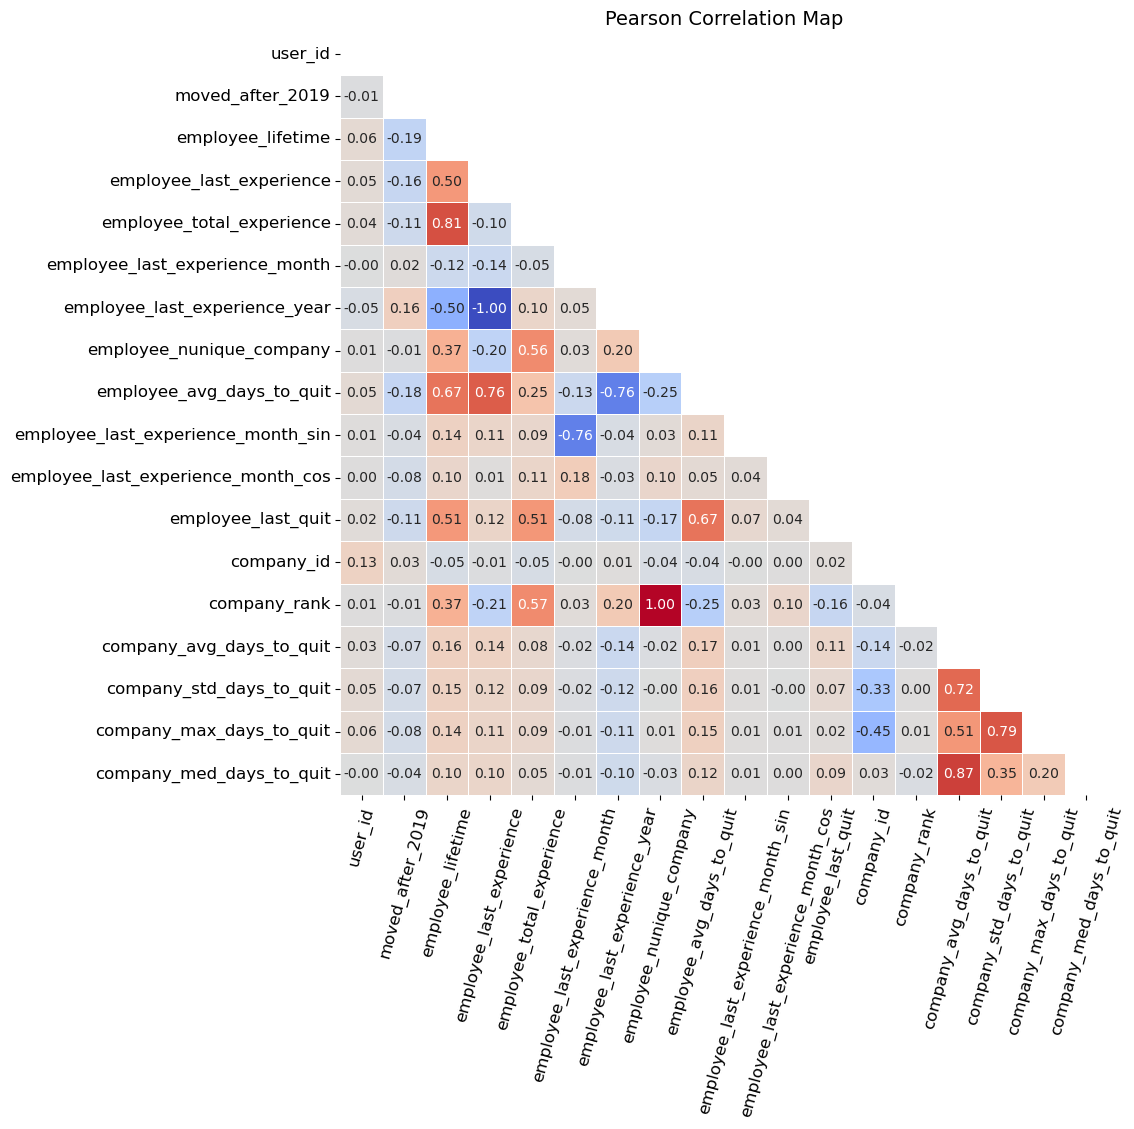

In [19]:
corr_map(df)

In [10]:
df.groupby(by = ['industry'], as_index=False).agg({'moved_after_2019': 'mean'}).sort_values('moved_after_2019')

,industry,moved_after_2019
137,Wine and Spirits,0.000
2,Alternative Dispute Resolution,0.000
135,Warehousing,0.000
107,Professional Training & Coaching,0.000
97,Package/Freight Delivery,0.000
...,...,...
129,Think Tanks,0.875
19,Commercial Real Estate,1.000
104,Political Organization,1.000
43,Fine Art,1.000


In [288]:
non_missing_df = df.loc[df["industry"].notnull()][
    [col for col in skills_df.columns] + ["industry"]
].dropna(subset=[col for col in df.columns if col.startswith("skill")])

search_df = df.loc[df["industry"].isnull()][
    [col for col in skills_df.columns] + ["industry"]
].dropna(subset=[col for col in df.columns if col.startswith("skill")])[
    non_missing_df.columns
]

print(search_df.shape)

(90, 122)


In [289]:
df['industry'].value_counts()

Computer Software                      21457
Information Technology and Services    13816
Telecommunications                      3647
Defense & Space                         2880
Banking                                 2016
                                       ...  
Fund-Raising                               2
Museums and Institutions                   2
Alternative Dispute Resolution             2
Dairy                                      2
Wine and Spirits                           1
Name: industry, Length: 140, dtype: int64

In [271]:
#non_missing_df = df.loc[df["industry"].notnull()][
#    [col for col in skills_df.columns] + ["industry"]
#].dropna(subset=[col for col in df.columns if col.startswith("skill")])
#
#search_df = df.loc[df["industry"].isnull()][
#    [col for col in skills_df.columns] + ["industry"]
#].dropna(subset=[col for col in df.columns if col.startswith("skill")])[
#    non_missing_df.columns
#]
#
#match_results = dict()
#for idx, row in search_df.iterrows():
#    employee = row['user_id']
#    missing_data_point = [row[col] for col in search_df.columns if col not in ['user_id', 'industry']]
#    manhattan_dist = np.abs(non_missing_df.drop(columns = ['user_id', 'industry'], axis = 1) - missing_data_point).sum(axis=1)
#    match_df = non_missing_df.assign(dist=manhattan_dist).copy()
#    #print(f"Employee: {employee}")
#
#    if manhattan_dist.min() < 2:
#        i = 1
#        while i < 10:
#            avg_dist = match_df.sort_values("dist")[:i]["dist"].mean()
#            if avg_dist > 1.25:
#                #print(avg_dist)
#                #print(match_industry)
#                break
#            match_industry = match_df.sort_values("dist")[:i]["industry"].mode().values[0]
#            #print(f"i: {i}")
#            #print(f"Average Distance: {avg_dist}")
#            #print(f"Industry Match: {match_industry}")
#            i += 1
#
#        match_results[employee] = match_industry
#    else:
#        continue
#
#match_results
#

In [290]:
#def fill_industry_with_skills(dataframe: pd.DataFrame, skills_dataframe: pd.DataFrame) -> pd.DataFrame:
#
#    df_ = dataframe.copy()
#    skills_df_ = skills_dataframe.copy()
#
#    non_missing_df = df_.loc[df_["industry"].notnull()][
#        [col for col in skills_df_.columns] + ["industry"]
#    ].dropna(subset=[col for col in df_.columns if col.startswith("skill")])
#
#    search_df = df_.loc[df_["industry"].isnull()][
#        [col for col in skills_df_.columns] + ["industry"]
#    ].dropna(subset=[col for col in df_.columns if col.startswith("skill")])[
#        non_missing_df.columns
#    ]
#
#    match_results = dict()
#    for idx, row in search_df.iterrows():
#        employee = row['user_id']
#        missing_data_point = [row[col] for col in search_df.columns if col not in ['user_id', 'industry']]
#        manhattan_dist = np.abs(non_missing_df.drop(columns = ['user_id', 'industry'], axis = 1) - missing_data_point).sum(axis=1)
#        match_df = non_missing_df.assign(dist=manhattan_dist).copy()
#        #print(f"Employee: {employee}")
#
#        if manhattan_dist.min() < 3:
#            i = 1
#            while i < 10:
#                avg_dist = match_df.sort_values("dist")[:i]["dist"].mean()
#                if avg_dist > 4.5:
#                    #print(avg_dist)
#                    #print(match_industry)
#                    break
#                match_industry = match_df.sort_values("dist")[:i]["industry"].mode().values[0]
#                #print(f"i: {i}")
#                #print(f"Average Distance: {avg_dist}")
#                #print(f"Industry Match: {match_industry}")
#                i += 1
#
#            match_results[employee] = match_industry
#        else:
#            match_industry = match_df.sort_values("dist")[:i]["industry"].mode().values[0]
#            match_results[employee] = match_industry
#            continue
#
#        del match_df
#        gc.collect()
#
#    print(f'industry matches: {len(match_results)}')
#    for key in match_results.keys():
#        df_.loc[df_['user_id'] == key, 'industry'] = match_results[key]
#
#    return df_
#
#df = fill_industry_with_skills(df, skills_df)
#df.head()

In [291]:
#fill_industry_with_skills(df, skills_df)

In [116]:
#manhattan_dist = np.abs(df - query_data_point).sum(axis=1)

#manhattan_dist

In [117]:
#df.groupby(by = 'industry' ,as_index=False).agg({'skill_administration': 'mean'}).sort_values('skill_administration')